In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

import cv2
import imghdr

import matplotlib.pyplot as plt

In [3]:
!ls JMD-DataSet

1.jpeg  14.jpeg 19.jpg  23.jpeg 28.jpeg 32.jpg  37.jpg  41.png  6.jpeg
10.jpeg 15.jpeg 2.jpeg  24.jpeg 29.jpg  33.jpg  38.jpg  42.jpg  7.jpeg
11.jpeg 16.jpg  20.jpg  25.jpeg 3.jpeg  34.jpg  39.jpg  43.jpg  8.jpeg
12.jpeg 17.jpg  21.jpg  26.jpeg 30.jpg  35.jpg  4.jpeg  44.jpeg 9.jpg
13.jpeg 18.jpg  22.jpg  27.jpeg 31.jpg  36.jpg  40.heic 5.jpeg


In [4]:
def check_images( s_dir, ext_list):
    bad_images = []
    bad_ext = []
    s_list = os.listdir(s_dir)
    for klass in s_list:
        klass_path = os.path.join (s_dir, klass)
        print ('Processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list = os.listdir(klass_path)
            for f in file_list:               
                f_path = os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        shape = img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                        os.remove(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir = r'/Users/simonlee/Desktop/KDDA 2/Final Project Data/JMD-DataSet'

# List of acceptable extensions
good_exts = ['jpg', 'png', 'jpeg', 'gif', 'bmp' ] 
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)

if len(bad_file_list) !=0:
    print('Please see improper image files listed below.')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print('No improper image files were found!')

Processing class directory  .DS_Store
*** WARNING*** you have files in  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataSet  it should only contain sub directories
Processing class directory  500
file  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataSet/500/.20211220_203321.jpg.icloud  is not a valid image file
file  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataSet/500/.20211220_202116.jpg.icloud  is not a valid image file
file  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataSet/500/.23.jpeg.icloud  is not a valid image file
file  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataSet/500/.39.jpg.icloud  is not a valid image file
file  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataSet/500/.20211220_202227.jpg.icloud  is not a valid image file
file  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataSet/500/.20211220_203249.jpg.icloud  is not a valid image file
file  /Users/winphyo/Documents/UWI/Semester-4/COMP6125/JMD-DataS

In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/simonlee/Desktop/KDDA 2/Final Project Data/JMD-DataSet",
    validation_split = 0.2,
    subset = "training",
    seed = 14,
    image_size = image_size,
    batch_size = batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/simonlee/Desktop/KDDA 2/Final Project Data/JMD-DataSet",
    validation_split = 0.2,
    subset = "validation",
    seed = 14,
    image_size = image_size,
    batch_size = batch_size,
)

Found 108 files belonging to 2 classes.
Using 87 files for training.
Found 108 files belonging to 2 classes.
Using 21 files for validation.


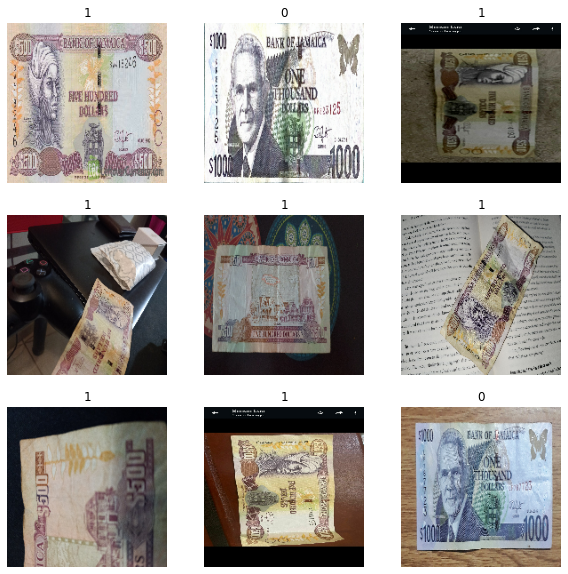

In [6]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

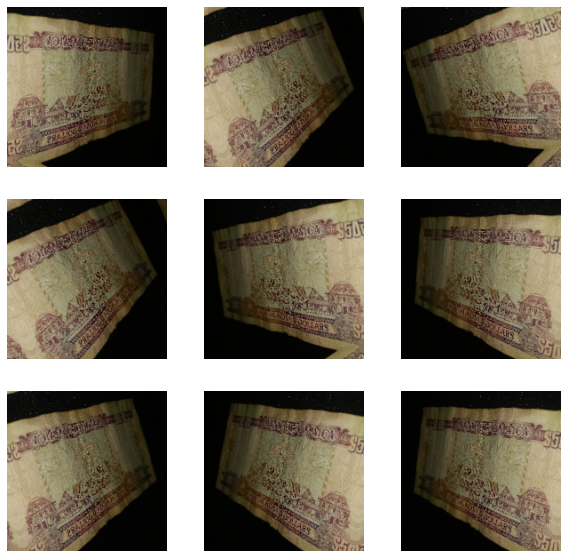

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y)
)

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
epochs = 3

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

model.save('dollar-model', save_format='h5')

3/3 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.6782

/Users/winphyo/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 23s 6s/step - loss: 0.5859 - accuracy: 0.6782 - val_loss: 0.6893 - val_accuracy: 0.5714
